# Run circuits on simulators and QPUs with Amazon Braket

In this hands-on lab, we demonstrate how you can 
1. Build a quantum circuit with the Amazon Braket SDK
2. Instantiate a quantum device object
3. Submit your circuit as a quantum task to the target device
4. Retrieve the results of the computation
5. Run Qiskit circuits directly on Braket

Let us begin by importing basic modules.

In [1]:
from braket.circuits import Circuit, Gate, circuit, observables
from braket.devices import LocalSimulator, Devices
from braket.aws import AwsDevice, AwsQuantumTask

import string
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

## Build a quantum circuit with the Braket SDK

To construct a circuit, we start by instantiating an emply quantum circuit object `Circuit()` and add quantum gates to the object. By convention the qubits are initiated in `0` state. Note that you don't need to intiate a predefined qubit register. The size of the register is dynamically allocated depending on the gates added while creating a circuit.

In [2]:
circ = Circuit()

### Gates supported by the Braket SDK

In [3]:
gate_set = [attr for attr in dir(Gate) if attr[0] in string.ascii_uppercase]
print('Gate set supported by SDK:\n', gate_set)

Gate set supported by SDK:
 ['CCNot', 'CNot', 'CPhaseShift', 'CPhaseShift00', 'CPhaseShift01', 'CPhaseShift10', 'CSwap', 'CV', 'CY', 'CZ', 'ECR', 'GPhase', 'GPi', 'GPi2', 'H', 'I', 'ISwap', 'MS', 'PRx', 'PSwap', 'PhaseShift', 'PulseGate', 'Rx', 'Ry', 'Rz', 'S', 'Si', 'Swap', 'T', 'Ti', 'U', 'Unitary', 'V', 'Vi', 'X', 'XX', 'XY', 'Y', 'YY', 'Z', 'ZZ']


### Let's build an example circuit

In [4]:
@circuit.subroutine(register=True)
def ghz(n_qubits):
    """
    function to return a GHZ circuit ansatz
    input: number of qubits
    """
    # instantiate circuit object
    circuit = Circuit()
    # add Hadamard gate on first qubit
    circuit.h(0)
    # apply series of CNOT gates
    for ii in range(0, n_qubits-1):
        circuit.cnot(control=ii, target=ii+1)
    return circuit

In [5]:
circ = Circuit()
circ.ghz(3)

print(circ)

T  : │  0  │  1  │  2  │
      ┌───┐             
q0 : ─┤ H ├───●─────────
      └───┘   │         
            ┌─┴─┐       
q1 : ───────┤ X ├───●───
            └───┘   │   
                  ┌─┴─┐ 
q2 : ─────────────┤ X ├─
                  └───┘ 
T  : │  0  │  1  │  2  │


## Execute the circuit on a local simulator and retrieve the results

In addition to the functionality to build quantum circuit, the Amazon Braket SDK comes with three local simulators allowing to execute your tasks in your local environment:
* state vector simulator (`default` / `braket_sv`)
* density matrix simulator (`braket_dm`)
* simulator for Analog Hamiltonian Simulation (`braket_ahs`)

The local simulator is recommended for rapid prototyping, circuit development and debugging.
More information about supported devices can be found in the [developer guide](https://docs.aws.amazon.com/braket/latest/developerguide/braket-devices.html).

### Instantiate the local state vector simulator

In [6]:
device = LocalSimulator()

### Create a quantum task

Now that we have instances of a circuit and a device, we can execute the circuit on the device by using the `device.run` API which creates a quantum task.

In [7]:
task = device.run(circ, shots=1000)
print(task, task.state())

LocalQuantumTask('id':34ee019b-b391-4219-8380-9befdd91796a) COMPLETED


Because we are executing our circuit on the local simulator, the task is a `LocalQuantumTask` which is executed synchroneously and - since the circuit is very small - completed almost immediately.

### Retrieve results of computation

We can now retrieve the results of the computation calling the `result` method on the task object.

In [8]:
result = task.result()
print(result)

GateModelQuantumTaskResult(task_metadata=TaskMetadata(braketSchemaHeader=BraketSchemaHeader(name='braket.task_result.task_metadata', version='1'), id='34ee019b-b391-4219-8380-9befdd91796a', shots=1000, deviceId='braket_sv', deviceParameters=None, createdAt=None, endedAt=None, status=None, failureReason=None), additional_metadata=AdditionalMetadata(action=Program(braketSchemaHeader=BraketSchemaHeader(name='braket.ir.openqasm.program', version='1'), source='OPENQASM 3.0;\nbit[3] b;\nqubit[3] q;\nh q[0];\ncnot q[0], q[1];\ncnot q[1], q[2];\nb[0] = measure q[0];\nb[1] = measure q[1];\nb[2] = measure q[2];', inputs={}), dwaveMetadata=None, ionqMetadata=None, rigettiMetadata=None, oqcMetadata=None, xanaduMetadata=None, queraMetadata=None, simulatorMetadata=None, iqmMetadata=None), result_types=[], values=[], measurements=array([[0, 0, 0],
       [1, 1, 1],
       [0, 0, 0],
       ...,
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]]), measured_qubits=[0, 1, 2], measurement_counts=Count

The result of our circuit execution is a `GateModelQuantumTaskResult`. You may review the properties of this object in the [Braket SDK documentation](https://amazon-braket-sdk-python.readthedocs.io/en/latest/_apidoc/braket.tasks.gate_model_quantum_task_result.html#braket.tasks.gate_model_quantum_task_result.GateModelQuantumTaskResult).

Let's print and visualize the count of binary strings for the measurements of each qubit in computational basis.

Counter({'000': 513, '111': 487}) <class 'collections.Counter'>


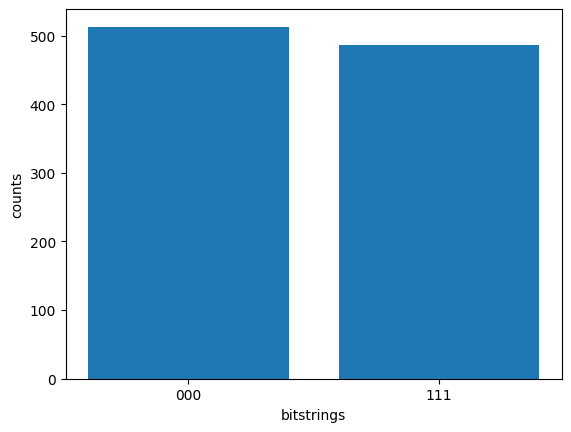

In [9]:
counts = result.measurement_counts
print(counts, type(counts))

# plot using Counter
plt.bar(counts.keys(), counts.values())
plt.xlabel('bitstrings')
plt.ylabel('counts')
plt.draw()

## Additional result types for circuit measurements

So far, we have only taken measurements in the computational basis. However, it is also possible to measure in other bases, as well as estimate quantities like expectation value and variance. We do this by appending additional `ResultTypes` to our circuit.

A list of all supported result types can be found in the [developer guide](https://docs.aws.amazon.com/braket/latest/developerguide/braket-result-types.html).

### Result types for shot-noise-free simulations

For shot-noise-free simulations (`shots=0`), result types like expecation value, variance, probability, etc. are computed exactly from the wavefunction. 
In addition, the local state vector simulator provides access to the full state vector and amplitudes of specified quantum states in the output wave function are supported for both the local and on-demand state vector simulators. 

In [10]:
# Let's consider our 3-qubit GHZ circuit
circ = Circuit().ghz(3)

# add the state vector result type
circ.state_vector()
# add the result type for amplitudes of the states |000> and |001>
circ.amplitude(state=["000", "001"])
# add expectation value for <Z0*Z1*Z2>
circ.expectation(
    observable=observables.Z() @ observables.Z() @ observables.Z(), 
    target=[0, 1, 2]
)

print(circ)

T  : │  0  │  1  │  2  │     Result Types     │
      ┌───┐             ┌────────────────────┐ 
q0 : ─┤ H ├───●─────────┤ Expectation(Z@Z@Z) ├─
      └───┘   │         └─────────┬──────────┘ 
            ┌─┴─┐       ┌─────────┴──────────┐ 
q1 : ───────┤ X ├───●───┤ Expectation(Z@Z@Z) ├─
            └───┘   │   └─────────┬──────────┘ 
                  ┌─┴─┐ ┌─────────┴──────────┐ 
q2 : ─────────────┤ X ├─┤ Expectation(Z@Z@Z) ├─
                  └───┘ └────────────────────┘ 
T  : │  0  │  1  │  2  │     Result Types     │

Additional result types: StateVector, Amplitude(000,001)


<div class="alert alert-block alert-info"> Note that <code>state_vector</code> and <code>amplitude</code> result types are only available for <code>shots=0</code>.</div>

In [11]:
device = LocalSimulator()
task = device.run(circ, shots=0)
result = task.result()
print("State Vector:", result.values[0], '\n')
print("Amplitudes:", result.values[1], '\n')
print("Expectation value of <Z0*Z1*Z2>:", result.values[2])

State Vector: [0.70710678+0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.70710678+0.j] 

Amplitudes: {'000': np.complex128(0.7071067811865475+0j), '001': np.complex128(0j)} 

Expectation value of <Z0*Z1*Z2>: 0.0


### Result types for simulations with shot noise

When `shots>0` we don't have access the full state vector, but we can still get approximate expectation values as taken from measurement samples. Note that probability, sample, expectation, and variance are also supported for QPUs.

In [12]:
circ = Circuit().ghz(3)

obs = observables.Z() @ observables.Z() @ observables.Z()
target_qubits = [0, 1, 2]

# add expectation value
circ.expectation(obs, target=target_qubits)
# add variance
circ.variance(obs, target=target_qubits)
# add samples
circ.sample(obs, target=target_qubits)

print(circ)

T  : │  0  │  1  │  2  │                        Result Types                        │
      ┌───┐             ┌────────────────────┐ ┌─────────────────┐ ┌───────────────┐ 
q0 : ─┤ H ├───●─────────┤ Expectation(Z@Z@Z) ├─┤ Variance(Z@Z@Z) ├─┤ Sample(Z@Z@Z) ├─
      └───┘   │         └─────────┬──────────┘ └────────┬────────┘ └───────┬───────┘ 
            ┌─┴─┐       ┌─────────┴──────────┐ ┌────────┴────────┐ ┌───────┴───────┐ 
q1 : ───────┤ X ├───●───┤ Expectation(Z@Z@Z) ├─┤ Variance(Z@Z@Z) ├─┤ Sample(Z@Z@Z) ├─
            └───┘   │   └─────────┬──────────┘ └────────┬────────┘ └───────┬───────┘ 
                  ┌─┴─┐ ┌─────────┴──────────┐ ┌────────┴────────┐ ┌───────┴───────┐ 
q2 : ─────────────┤ X ├─┤ Expectation(Z@Z@Z) ├─┤ Variance(Z@Z@Z) ├─┤ Sample(Z@Z@Z) ├─
                  └───┘ └────────────────────┘ └─────────────────┘ └───────────────┘ 
T  : │  0  │  1  │  2  │                        Result Types                        │


<div class="alert alert-block alert-info"> Note that <code>sample</code> result type is only available for <code>shots>0</code>.</div>

In [13]:
device = LocalSimulator()
task = device.run(circ, shots=100)
result = task.result()
print("Expectation value for <Z0*Z1*Z2>:", result.values[0])
print("Variance for <Z0*Z1*Z2>:", result.values[1])
print("Measurement samples for <Z0*Z1*Z2>:", result.values[2])

Expectation value for <Z0*Z1*Z2>: -0.04
Variance for <Z0*Z1*Z2>: 0.9983999999999997
Measurement samples for <Z0*Z1*Z2>: [ 1.  1.  1.  1.  1.  1. -1. -1. -1. -1.  1. -1. -1. -1. -1. -1.  1. -1.
  1. -1. -1.  1.  1.  1. -1.  1. -1. -1.  1. -1. -1. -1. -1. -1. -1.  1.
  1. -1.  1.  1. -1. -1.  1. -1. -1.  1. -1.  1. -1. -1. -1. -1. -1. -1.
 -1. -1.  1.  1. -1.  1. -1. -1.  1.  1.  1. -1.  1.  1.  1. -1.  1.  1.
  1. -1.  1.  1. -1. -1.  1.  1.  1. -1.  1. -1.  1. -1. -1. -1. -1.  1.
  1.  1.  1.  1.  1.  1. -1. -1.  1. -1.]


## Execute your circuit on a real QPU

Executing a circuit on a real QPU is not different to what we have done before.

Let's consider a 10-qubit GHZ circuit:

In [14]:
circ = Circuit().ghz(10)

print(circ)

T  : │  0  │  1  │  2  │  3  │  4  │  5  │  6  │  7  │  8  │  9  │
      ┌───┐                                                       
q0 : ─┤ H ├───●───────────────────────────────────────────────────
      └───┘   │                                                   
            ┌─┴─┐                                                 
q1 : ───────┤ X ├───●─────────────────────────────────────────────
            └───┘   │                                             
                  ┌─┴─┐                                           
q2 : ─────────────┤ X ├───●───────────────────────────────────────
                  └───┘   │                                       
                        ┌─┴─┐                                     
q3 : ───────────────────┤ X ├───●─────────────────────────────────
                        └───┘   │                                 
                              ┌─┴─┐                               
q4 : ─────────────────────────┤ X ├───●───────────────────────

Now, let's check programmatically which QPUs are currently available:

In [15]:
AwsDevice.get_devices(types=['QPU'], statuses=['ONLINE'])

[Device('name': Ankaa-2, 'arn': arn:aws:braket:us-west-1::device/qpu/rigetti/Ankaa-2),
 Device('name': Aquila, 'arn': arn:aws:braket:us-east-1::device/qpu/quera/Aquila),
 Device('name': Aria 1, 'arn': arn:aws:braket:us-east-1::device/qpu/ionq/Aria-1),
 Device('name': Forte 1, 'arn': arn:aws:braket:us-east-1::device/qpu/ionq/Forte-1),
 Device('name': Garnet, 'arn': arn:aws:braket:eu-north-1::device/qpu/iqm/Garnet)]

Again, we only have to instantiate a device object and invoke the `device.run` function to create a quantum task. Because we want to run on a real Braket backend, we have to use the `AwsDevice` module.

In [16]:
#device = AwsDevice(Devices.IQM.Garnet)
#device = AwsDevice(Devices.IonQ.Forte1)
device=junk
task = device.run(circ, shots=120)
print(task.id, task.state())

NameError: name 'junk' is not defined

### When will my task run?

Unlike on-demand simulators, QPUs are not a scalable resource. Therefore, your task may remain in `CREATED` or `QUEUED` state for some time. Reasons for this may be device availability windows and other tasks already created and queued.

Before you create a quantum task, you can view how many other quantum tasks are already in front of you by checking device queue depth.

After you have created a task, you can view the current position of your quantum task within a respective device queue.

In [ ]:
print(device.queue_depth(), '\n')
print(task.queue_position())

More information about queue visibility can be found in the [Braket developer guide](https://docs.aws.amazon.com/braket/latest/developerguide/braket-task-when.html#braket-queue-visibility).

In [ ]:
print(task.id, task.state())

### Low level access and device native programming

Usually, when you run a circuit on a QPU, behind the scenes, Amazon Braket will do a series of compilation steps to optimize your circuit and map the abstract circuit to the physical qubits on the QPU. One of the steps is to decompose the gates of your circuit into the _native gates_ of the QPU. 

We can check the list of native gates for each QPU:

In [ ]:
for qpu in AwsDevice.get_devices(types=['QPU'], order_by='provider_name'):
    if qpu.properties.paradigm.braketSchemaHeader.name == 'braket.device_schema.gate_model_qpu_paradigm_properties':
        print(f'{qpu.name} native gates: {qpu.properties.paradigm.nativeGateSet}')

#### Working with OpenQASM

Amazon Braket uses OpenQASM 3.0 as the Intermediate Representation for gate-based quantum devices. You have the choice of submitting Braket circuits built with the constructs provided by the SDK or by directly providing OpenQASM 3.0 strings to all gate-based devices.
In [this notebook](https://github.com/amazon-braket/amazon-braket-examples/blob/main/examples/braket_features/Getting_Started_with_OpenQASM_on_Braket.ipynb) we demonstrate how to submit a quantum task for an OpenQASM circuit. To learn more about simulation of advanced OpenQASM programs with the `LocalSimulator` see [this notebook](https://github.com/amazon-braket/amazon-braket-examples/blob/main/examples/braket_features/Simulating_Advanced_OpenQASM_Programs_with_the_Local_Simulator.ipynb).

#### Verbatim Compilation

In some situations, such as for error mitigation or benchmarking experiments, researchers require full control of the qubits and the gates that are being applied. To run your circuits exactly as defined without any modification during the compilation process, you can use the _verbatim compilation_ feature of Braket.

Check out [this notebook](https://github.com/amazon-braket/amazon-braket-examples/blob/main/examples/braket_features/Verbatim_Compilation.ipynb) to learn how to use verbatim compliation.

#### Pulse level control

Pulses are the analog signals that control the qubits in a quantum computer. With certain devices on Amazon Braket, you can access the pulse control feature to submit circuits using pulses. You can access pulse control through the `Braket SDK`, using `OpenQASM 3.0`, or directly through the `Braket APIs`. You can read more about pulse control on Amazon Braket in the [developer guide](https://docs.aws.amazon.com/braket/latest/developerguide/braket-pulse-control.html).

For an example of pulse level control on Amazon Braket, take a look the [available example notebooks](https://github.com/amazon-braket/amazon-braket-examples/tree/main/examples/pulse_control).

### Task recovery

You may have closed your Python session or stopped your Braket notebook instance while your quantum task has been queued. When you come back at a later point in time you can still continue and retrieve the result of the computation. 

In that case, it is conventient to (re-)created the `AwsQuantumTask` object of your task. All you need to know the the Amazon Resource Name (ARN) of your task.

In [ ]:
task_arn = task.id
# task_arn = ''

print(task_arn)

In [ ]:
from braket.aws import AwsQuantumTask

recovered_task = AwsQuantumTask(arn=task_arn)

# print the real-time status of the task
print('Status of (reconstructed) task:', recovered_task.state())

In [ ]:
if recovered_task.state() == 'COMPLETED':
    # get task results
    qpu_results = recovered_task.result()

    metadata = recovered_task.metadata()
    print("{} shots taken on machine {}.\n".format(metadata['shots'], metadata['deviceArn']))

    qpu_counts = qpu_results.measurement_counts
    print('Measurement counts:', qpu_counts)

    plt.bar(qpu_counts.keys(), qpu_counts.values())
    plt.xlabel('bitstrings')
    plt.xticks(rotation=90)
    plt.ylabel('counts')
    plt.tight_layout()
else:
    # print current status
    print(f'Sorry, your task is not (yet) completed, but in state {recovered_task.state()}')

### Access the compiled program

The task result also contains the OpenQASM string of the complied circuit in terms of the device-specific native gates:

In [ ]:
compiled_circuit = recovered_task.result().additional_metadata.iqmMetadata.compiledProgram
print(compiled_circuit)

## Working with Qiskit

If you prefer to build your quantum circuits with Qiskit you can continue to use it and run your Qiskit code across any of the gate-based devices on the Amazon Braket with open-source the [Qiskit-Braket provider](https://github.com/qiskit-community/qiskit-braket-provider).

In [ ]:
from qiskit_braket_provider import BraketLocalBackend
from qiskit_braket_provider import BraketProvider

provider = BraketProvider()

In [ ]:
provider.backends(statuses=["ONLINE"])

### Define a qiskit circuit

In [ ]:
from qiskit import QuantumCircuit

def qiskit_ghz(n):
    circuit = QuantumCircuit(n)
    circuit.h(0)
    for ii in range(0, n-1):
        circuit.cx(ii, ii+1)
    return circuit

In [ ]:
ghz_qiskit = qiskit_ghz(10)
ghz_qiskit.draw()

### Run Qiskit code on the Braket SDK LocalSimulator

In [ ]:
local_simulator = BraketLocalBackend()

simulator_task = local_simulator.run(ghz_qiskit, shots=1000)

result = simulator_task.result()
result_counts = result.data()['counts']
print(result_counts)

plt.bar(result_counts.keys(), result_counts.values())
plt.show()

### Run Qiskit circuit on a QPU available on Braket

In [ ]:
qpu_backend = provider.get_backend("Garnet")

qpu_task = qpu_backend.run(ghz_qiskit, shots=1000)

In [ ]:
task_id = qpu_task.task_id()
task_id

In [ ]:
task=AwsQuantumTask('arn:aws:braket:eu-north-1:977230113265:quantum-task/cb00b12e-e916-47aa-b530-fd07b6b0b6f6')
task.metadata

In [ ]:
qpu_task.status()

### Retrieve quantum task data

In [ ]:
retrieved_task = qpu_backend.retrieve_job(task_id=task_arn)
retrieved_task.status()

We can plot the histogram of the measurement counts:

In [ ]:
result = retrieved_task.result()
result_counts = result.data()['counts']

plt.bar(result_counts.keys(), result_counts.values())
plt.xlabel('bitstrings')
plt.xticks(rotation=90)
plt.ylabel('counts')
plt.tight_layout()
plt.show()

## Call to action

In this notebook, you have learned 
* how to use the Amazon Braket SDK to
  * build a circuit 
  * run a circuit as a task on the local simulator and on a real QPU on Amazon Braket
  * track the task lifecycle and retrieve the result upon task completion
* how you can run Qiskit circuits directly on Braket using the open-source Qiskit-Braket provider.

<div class="alert alert-block alert-info"> 
<b>You have access to this environment for the rest of the week. We encourage you to use it to explore Amazon Braket at your own pace. We are here for the rest of the day to help you. Please don't hesitate to approach us.</b>
</div>

And check out the following resources to continue learning about Amazon Braket:
* [Amazon Braket web page](https://aws.amazon.com/braket/)
* [Amazon Braket examples GitHub repository](https://github.com/amazon-braket/amazon-braket-examples)
* [AWS Quantum Technologies Blog](https://aws.amazon.com/blogs/quantum-computing/)

